## Install (Colab Only)

In [ ]:
# install
!pip install pyepo
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 3.6 MB/s eta 0:00:00


Remove the problematic hook from Google Colab.

In [ ]:
import sys
sys.meta_path = [hook for hook in sys.meta_path if not any(keyword in str(hook) for keyword in ["google.colab"])]

# Training and Testing


In [ ]:
# set random seed
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In this tutorial, we will train and test end-to-end predict-then-optimize for different approaches.

## 1 Problem Example: Shortest Path

Consider a 5x5 grid network again. The figure shows that each node has top, bottom, left, and right neighbors. We aim to find the shortest path from left top to right bottom.

<img src="https://github.com/khalil-research/PyEPO/blob/main/images/shortestpath.png?raw=1" width="500">

The weighted graph includes 25 nodes and 40 edges. The weights of the edges are the costs of the path. We load the synthetic dataset where the costs $\mathbf{c}$ are unknown and can be predicted from features $\mathbf{x}$.

``pyepo.data.shortestpath.genData`` allows us to generate data with various size, polynomial degree, and noise. We can learn more about the dataset [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/02%20Optimization%20Dataset.ipynb).

In [ ]:
import pyepo
# generate data
grid = (5,5) # grid size
num_data = 1000 # number of training data
num_feat = 5 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=42)

Auto-Sklearn cannot be imported.


Thus, we can use ``optGrbModel`` to build a linear model with the Gurobi solver. For more details on ``optModel``, you can read tutorial [01 Optimization Model
](https://github.com/khalil-research/PyEPO/blob/main/notebooks/01%20Optimization%20Model.ipynb) and [documentation](https://khalil-research.github.io/PyEPO/build/html/content/examples/model.html).

In [ ]:
# build optModel
from pyepo.model.grb import optGrbModel

class shortestPathModel(optGrbModel):

    def __init__(self):
        self.grid = (5,5)
        self.arcs = self._getArcs()
        super().__init__()

    def _getArcs(self):
        """
        A helper method to get list of arcs for grid network

        Returns:
            list: arcs
        """
        arcs = []
        for i in range(self.grid[0]):
            # edges on rows
            for j in range(self.grid[1] - 1):
                v = i * self.grid[1] + j
                arcs.append((v, v + 1))
            # edges in columns
            if i == self.grid[0] - 1:
                continue
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                arcs.append((v, v + self.grid[1]))
        return arcs

    def _getModel(self):
        """
        A method to build Gurobi model

        Returns:
            tuple: optimization model and variables
        """
        import gurobipy as gp
        from gurobipy import GRB
        # ceate a model
        m = gp.Model("shortest path")
        # varibles
        x = m.addVars(self.arcs, name="x")
        # sense
        m.modelSense = GRB.MINIMIZE
        # flow conservation constraints
        for i in range(self.grid[0]):
            for j in range(self.grid[1]):
                v = i * self.grid[1] + j
                expr = 0
                for e in self.arcs:
                    # flow in
                    if v == e[1]:
                        expr += x[e]
                    # flow out
                    elif v == e[0]:
                        expr -= x[e]
                # source
                if i == 0 and j == 0:
                    m.addConstr(expr == -1)
                # sink
                elif i == self.grid[0] - 1 and j == self.grid[0] - 1:
                    m.addConstr(expr == 1)
                # transition
                else:
                    m.addConstr(expr == 0)
        return m, x

In [ ]:
optmodel = shortestPathModel()

Restricted license - for non-production use only - expires 2026-11-23


## 2 Dataset and Data Loader

PyTorch provides two data primitives: ``Dataset`` and ``DataLoader``, which allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples. The PyEPO module ``optDataset`` stores features $\mathbf{x}$ and costs $\mathbf{c}$, then computes the corresponding optimal solutions $\mathbf{w}^*$ and objective values $\mathbf{z}^*$.

More details on ``optDataset`` is [here](https://github.com/khalil-research/PyEPO/blob/main/notebooks/02%20Optimization%20Dataset.ipynb).

In [ ]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [ ]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:01<00:00, 509.24it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:01<00:00, 957.18it/s]


In [ ]:
# set data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## 3 Linear Regression on PyTorch

PyTorch is an open-source machine learning library primarily used for developing and training deep learning models such as neural networks. It is developed by Facebook's AI Research lab and is based on the Torch library. PyTorch provides a flexible and intuitive interface for creating and training models.

In PyTorch, the ``nn.Module`` is a base class for all neural network modules in the library. It provides a convenient way to organize the layers of a model, and to define the forward pass of the model.

Here, we build the simplest PyTorch model, linear regression.

In [ ]:
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

Then, we can initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()

## 4 Training and Testing

The core capability of PyEPO is to build optimization models with GurobiPy, Pyomo, or any other solvers and algorithms, then embed the optimization model into an artificial neural network for the end-to-end training. For this purpose, PyEPO implements **SPO+ loss** and **differentiable Black-Box optimizer**, **differentiable perturbed optimizer**, **Fenchel-Young loss with Perturbation**, **Noise Contrastive Estimation**, and **Learning to Rank** as PyTorch autograd modules.

We will train and test the above aproaches.

### 4.1 Introduction to Metrics

``pyepo.metric.regret`` is to evaluate model performance. Regret (also called SPO loss) $l_{Regret}(\hat{\mathbf{c}}, \mathbf{c}) = \mathbf{c}^T \mathbf{w}^*_{\hat{\mathbf{c}}} - z^*_{\mathbf{c}}$ aims to measure the error in decision-making. It evaluates the distance between the objective value of the solution from predicted cost $\hat{\mathbf{c}}$ and the true optimal objective value $z^*_{c}$.

To calculate regret, ``pyepo.metric.regret`` requires:
- ``predmodel``: a regression neural network for cost prediction
- ``optmodel``: an PyEPO optimization model
- ``dataloader``: PyTorch dataloader from optDataset to evaluate

The following code block is an example:

In [ ]:
import pyepo
regret = pyepo.metric.regret(reg, optmodel, loader_test)

### 4.2 Functions

Define function to train model with different methods.

In [ ]:
import time

# train model
def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name in ["ptb", "pfy", "imle", "aimle", "nce", "cmap"]:
                loss = loss_func(cp, w)
            if method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            if method_name in ["pg", "ltr"]:
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

Define functions that visualize the learning curves.

In [ ]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

### 4.3 Surrogate Loss

#### 4.3.1 Smart Predict-then-Optimize

[Elmachtoub, A. N., & Grigas, P. (2022). Smart “predict, then optimize”. Management Science, 68(1), 9-26.](https://doi.org/10.1287/mnsc.2020.3922)

SPO+ Loss is a surrogate loss function of SPO Loss (Regret), which measures the decision error of optimization problem. For SPO/SPO+ Loss, the objective function is linear and constraints are known and fixed, but the cost vector need to be predicted from contextual data. The SPO+ Loss is convex with non-zero subgradient. Thus, allows us to design an algorithm based on stochastic gradient descent.

First of all, we initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.SPOPlus`` allows us to set a SPO+ loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores

In [ ]:
# init SPO+ loss
spop = pyepo.func.SPOPlus(optmodel, processes=2)

Num of cores: 2


##### Training

Then, we can train a linear predictor with SPO+ loss to predict unknown cost coefficients and make decisions.

To compute SPO+ loss, ``spop`` requires $\mathbf{\hat{c}}$, $\mathbf{c}$, $\mathbf{w}^*_{\mathbf{c}}$, and $\mathbf{z}^*_{\mathbf{c}}$.

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=spop, method_name="spo+")

Epoch  1,  Loss:    2.3026,  Regret: 11.0720%
Epoch  2,  Loss:    1.3455,  Regret:  8.2444%
Epoch  3,  Loss:    1.6723,  Regret:  7.4430%
Epoch  4,  Loss:    1.1063,  Regret:  7.0685%
Epoch  5,  Loss:    1.0820,  Regret:  7.1374%
Epoch  6,  Loss:    1.3178,  Regret:  7.3276%
Epoch  7,  Loss:    1.5822,  Regret:  7.2296%
Epoch  8,  Loss:    0.7266,  Regret:  7.3548%
Epoch  9,  Loss:    0.5989,  Regret:  7.4255%
Epoch 10,  Loss:    0.9826,  Regret:  7.6219%
Epoch 11,  Loss:    0.7405,  Regret:  7.1146%
Epoch 12,  Loss:    0.8847,  Regret:  7.6052%
Epoch 13,  Loss:    0.9451,  Regret:  7.2431%
Epoch 14,  Loss:    0.5897,  Regret:  7.4689%
Epoch 15,  Loss:    1.5206,  Regret:  7.3123%
Epoch 16,  Loss:    0.5411,  Regret:  7.3580%
Epoch 17,  Loss:    0.6211,  Regret:  6.9684%
Epoch 18,  Loss:    1.0540,  Regret:  7.5942%
Epoch 19,  Loss:    1.4707,  Regret:  7.1119%
Epoch 20,  Loss:    0.9712,  Regret:  7.4135%
Total Elapsed Time: 1199.16 Sec.


##### Learning Curve

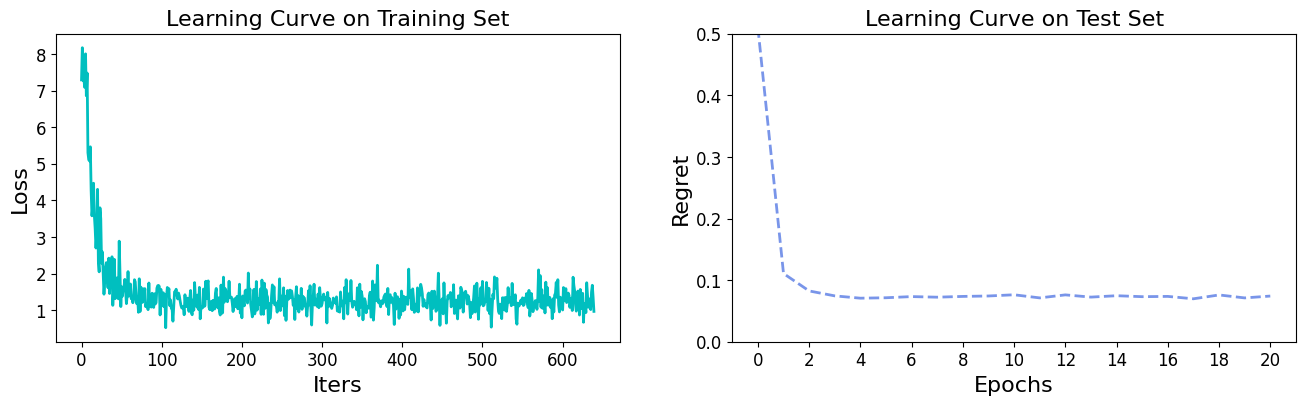

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

#### 4.3.2 Perturbation Gradient

[Decision-Focused Learning with Directional Gradients
](https://arxiv.org/abs/2402.03256)

PG Loss is a surrogate loss function of objective value, which measures the decision quality of the optimization problem. For PG Loss, the objective function is linear, and constraints are known and fixed, but the cost vector needs to be predicted from contextual data.

According to Danskin’s Theorem, the PG Loss is derived from different zeroth order approximations and has the informative gradient. Thus, it allows us to design an algorithm based on stochastic gradient descent.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

##### Training

Then, we can train a linear predictor with PG loss to predict unknown cost coefficients and make decisions.

To compute PG loss, ``pg`` requires $\mathbf{\hat{c}}$, $\mathbf{c}$.

In [ ]:
# init PG loss
pg = pyepo.func.perturbationGradient(optmodel, sigma=0.1, two_sides=False, processes=2)

Num of cores: 2


In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=pg, method_name="pg")

Epoch  1,  Loss:    6.4251,  Regret: 35.1312%
Epoch  2,  Loss:    6.2989,  Regret: 28.4239%
Epoch  3,  Loss:    5.4633,  Regret: 24.5667%
Epoch  4,  Loss:    6.3356,  Regret: 22.0874%
Epoch  5,  Loss:    3.1061,  Regret: 19.2584%
Epoch  6,  Loss:    3.6650,  Regret: 16.4713%
Epoch  7,  Loss:    4.6143,  Regret: 15.2981%
Epoch  8,  Loss:    3.4128,  Regret: 14.9897%
Epoch  9,  Loss:    3.0740,  Regret: 15.1525%
Epoch 10,  Loss:    4.8770,  Regret: 14.4513%
Epoch 11,  Loss:    3.8764,  Regret: 14.5125%
Epoch 12,  Loss:    4.6737,  Regret: 14.2201%
Epoch 13,  Loss:    5.2031,  Regret: 14.1166%
Epoch 14,  Loss:    3.4218,  Regret: 13.8259%
Epoch 15,  Loss:    4.7395,  Regret: 13.7884%
Epoch 16,  Loss:    4.9377,  Regret: 13.8185%
Epoch 17,  Loss:    3.6126,  Regret: 13.6943%
Epoch 18,  Loss:    4.1226,  Regret: 13.7249%
Epoch 19,  Loss:    4.5827,  Regret: 14.2383%
Epoch 20,  Loss:    4.7709,  Regret: 13.7549%
Total Elapsed Time: 2395.00 Sec.


##### Learning Curve

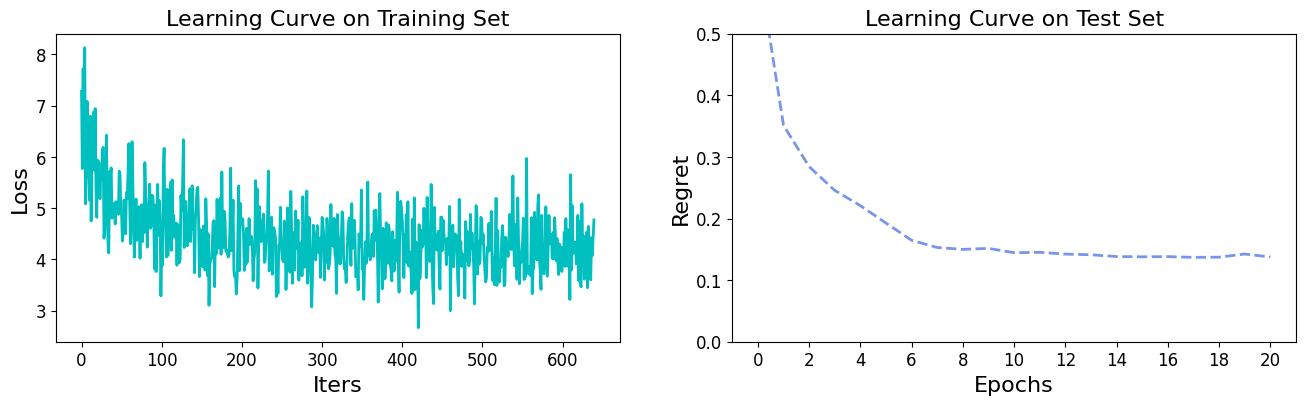

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

### 4.4 Perturbed Methods

[Berthet, Q., Blondel, M., Teboul, O., Cuturi, M., Vert, J. P., & Bach, F. (2020). Learning with differentiable pertubed optimizers. Advances in neural information processing systems, 33, 9508-9519.](https://papers.nips.cc/paper/2020/hash/6bb56208f672af0dd65451f869fedfd9-Abstract.html)

[Niepert, M., Minervini, P., & Franceschi, L. (2021). Implicit MLE: backpropagating through discrete exponential family distributions. Advances in Neural Information Processing Systems, 34, 14567-14579.](https://proceedings.neurips.cc/paper_files/paper/2021/hash/7a430339c10c642c4b2251756fd1b484-Abstract.html)

#### 4.4.1 Differentiable Perturbed Optimizer

Differentiable perturbed optimizer uses Monte-Carlo samples to estimate solutions, in which randomly perturbed costs are sampled to optimize. For the perturbed optimizer, the cost vector needs to be predicted from contextual data and are perturbed with Gaussian noise. The perturbed optimizer is differentiable in its inputs with non-zero Jacobian, thus allowing us to design an algorithm based on stochastic gradient descent.

First of all, we initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedOpt`` allows us to set a SPO+ loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

Unlike SPO+, PTB is not a loss function so we need to define a loss.

In [ ]:
# init ptb solver
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=3, sigma=1.0, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def ptbl1(cp, w):
    # perturbed optimizer
    we = ptb(cp)
    # loss
    loss = l1(we, w)
    return loss

Num of cores: 2


##### Training

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=ptbl1, method_name="ptb")

Epoch  1,  Loss:    0.2771,  Regret: 34.2065%
Epoch  2,  Loss:    0.2458,  Regret: 26.5737%
Epoch  3,  Loss:    0.2479,  Regret: 22.0910%
Epoch  4,  Loss:    0.2354,  Regret: 19.2805%
Epoch  5,  Loss:    0.2396,  Regret: 16.2769%
Epoch  6,  Loss:    0.2042,  Regret: 14.4049%
Epoch  7,  Loss:    0.1583,  Regret: 13.8019%
Epoch  8,  Loss:    0.1562,  Regret: 12.6637%
Epoch  9,  Loss:    0.2062,  Regret: 11.6484%
Epoch 10,  Loss:    0.2375,  Regret: 10.6089%
Epoch 11,  Loss:    0.1625,  Regret: 10.1212%
Epoch 12,  Loss:    0.1229,  Regret:  9.9272%
Epoch 13,  Loss:    0.1667,  Regret:  9.5590%
Epoch 14,  Loss:    0.1938,  Regret:  9.1513%
Epoch 15,  Loss:    0.1667,  Regret:  9.2448%
Epoch 16,  Loss:    0.1729,  Regret:  9.2872%
Epoch 17,  Loss:    0.2021,  Regret:  9.1291%
Epoch 18,  Loss:    0.1542,  Regret:  9.0793%
Epoch 19,  Loss:    0.1562,  Regret:  9.0779%
Epoch 20,  Loss:    0.1917,  Regret:  8.7496%
Total Elapsed Time: 2032.64 Sec.


##### Learning Curve

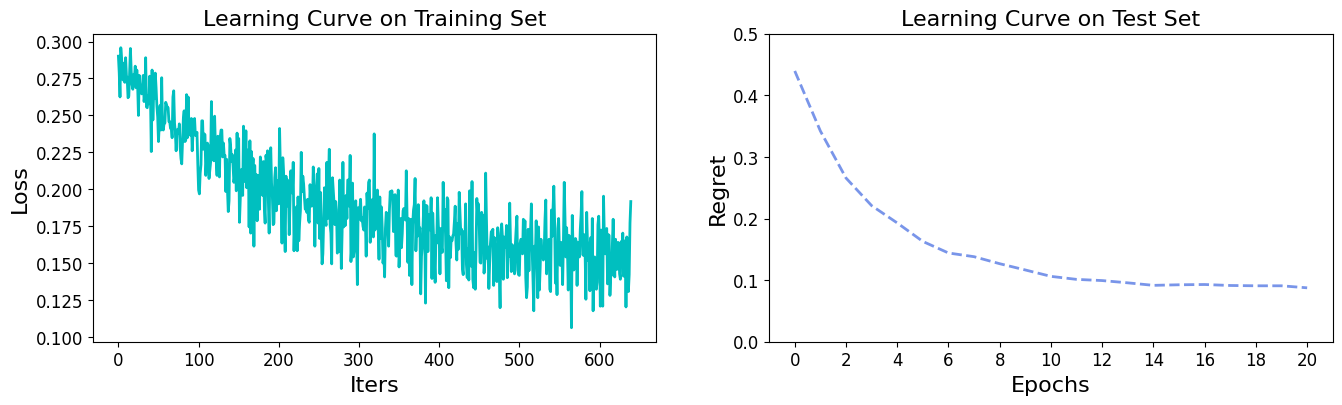

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

#### 4.4.2 Perturbed Fenchel-Young Loss

Perturbed Fenchel-Young loss (PYFL) uses perturbation techniques with Monte-Carlo samples. The use of the loss improves the algorithmic by the specific expression of the gradients of the loss. For the perturbed optimizer, the cost vector need to be predicted from contextual data and are perturbed with Gaussian noise. The Fenchel-Young loss allows to directly optimize a loss between the features and solutions with less computation. Thus, allows us to design an algorithm based on stochastic gradient descent.

First of all, we initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedFenchelYoung`` allows us to set a Fenchel-Young loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [ ]:
# init pfyl loss
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0, processes=2)

Num of cores: 2


##### Training

Then, we can train a linear predictor with Fenchel-Young loss to predict unknown cost coefficients and make decisions.

To compute Fenchel-Young loss, ``pfy`` requires $\mathbf{\hat{c}}$ and $\mathbf{w}^*_{\mathbf{c}}$.

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=pfy, method_name="pfy")

Epoch  1,  Loss:    5.7500,  Regret: 11.3902%
Epoch  2,  Loss:    5.0833,  Regret:  8.2703%
Epoch  3,  Loss:    3.9444,  Regret:  7.8452%
Epoch  4,  Loss:    2.9722,  Regret:  7.9306%
Epoch  5,  Loss:    3.3611,  Regret:  7.3821%
Epoch  6,  Loss:    4.5556,  Regret:  7.0737%
Epoch  7,  Loss:    4.0556,  Regret:  6.9765%
Epoch  8,  Loss:    2.5278,  Regret:  7.1756%
Epoch  9,  Loss:    5.5000,  Regret:  7.0683%
Epoch 10,  Loss:    5.3889,  Regret:  7.1082%
Epoch 11,  Loss:    4.0556,  Regret:  7.2430%
Epoch 12,  Loss:    2.8056,  Regret:  6.9974%
Epoch 13,  Loss:    5.3056,  Regret:  7.2882%
Epoch 14,  Loss:    6.6944,  Regret:  7.1869%
Epoch 15,  Loss:    4.2222,  Regret:  7.3201%
Epoch 16,  Loss:    4.3889,  Regret:  7.2658%
Epoch 17,  Loss:    3.9722,  Regret:  7.4577%
Epoch 18,  Loss:    4.2500,  Regret:  7.5223%
Epoch 19,  Loss:    4.4444,  Regret:  7.2957%
Epoch 20,  Loss:    6.8333,  Regret:  7.3768%
Total Elapsed Time: 1953.70 Sec.


##### Learning Curve

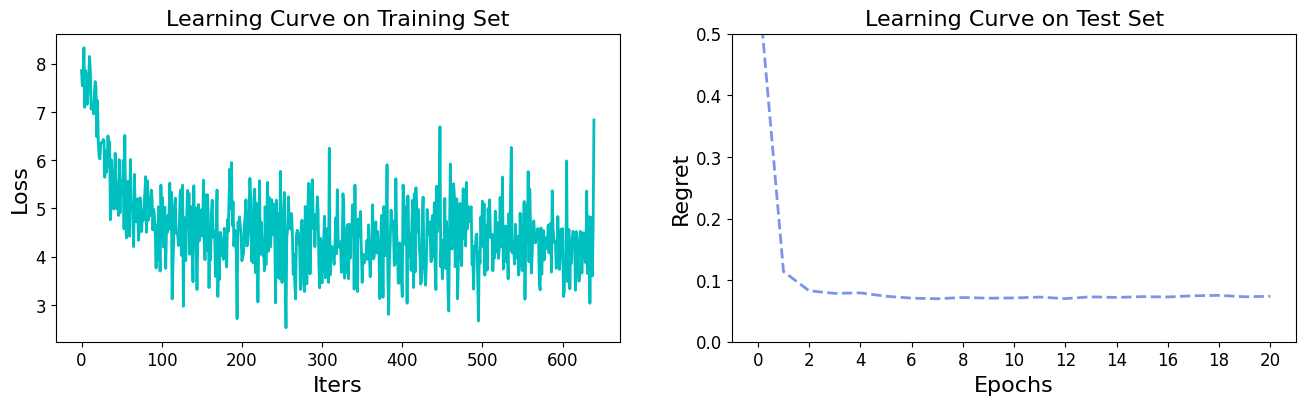

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

#### 4.4.3 Implicit Maximum Likelihood Estimator

Implicit Maximum Likelihood Estimator (I-MLE) use the perturb-and-MAP framework. They sample noise from a Sum-of-Gamma distribution and interpolate the loss function to approximate finite difference.

First of all, we initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.implicitMLE`` allows us to set a Maximum Likelihood loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``lambd``: a hyperparameter for differentiable block-box to control interpolation degree
- ``distribution``: noise distribution
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [ ]:
# init i-mle solver
imle = pyepo.func.implicitMLE(optmodel, n_samples=10, sigma=1.0, lambd=10, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def ilmel1(cp, w):
    # perturbed optimizer
    we = imle(cp)
    # loss
    loss = l1(we, w)
    return loss

Num of cores: 2


##### Training

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=ilmel1, method_name="imle")

Epoch  1,  Loss:    0.2819,  Regret: 30.9446%
Epoch  2,  Loss:    0.1656,  Regret: 21.3200%
Epoch  3,  Loss:    0.1675,  Regret: 17.8908%
Epoch  4,  Loss:    0.1856,  Regret: 14.8087%
Epoch  5,  Loss:    0.1788,  Regret: 14.2432%
Epoch  6,  Loss:    0.1675,  Regret: 13.3316%
Epoch  7,  Loss:    0.1706,  Regret: 11.1810%
Epoch  8,  Loss:    0.1425,  Regret: 11.0198%
Epoch  9,  Loss:    0.1581,  Regret:  9.9578%
Epoch 10,  Loss:    0.1606,  Regret: 10.3809%
Epoch 11,  Loss:    0.1863,  Regret:  9.2592%
Epoch 12,  Loss:    0.1431,  Regret:  8.5203%
Epoch 13,  Loss:    0.1381,  Regret:  9.1318%
Epoch 14,  Loss:    0.1294,  Regret:  9.0275%
Epoch 15,  Loss:    0.1231,  Regret:  8.9487%
Epoch 16,  Loss:    0.1388,  Regret:  8.9237%
Epoch 17,  Loss:    0.2169,  Regret:  8.5941%
Epoch 18,  Loss:    0.1575,  Regret:  8.7159%
Epoch 19,  Loss:    0.1088,  Regret:  8.6779%
Epoch 20,  Loss:    0.1200,  Regret:  9.0215%
Total Elapsed Time: 9517.89 Sec.


##### Learning Curve

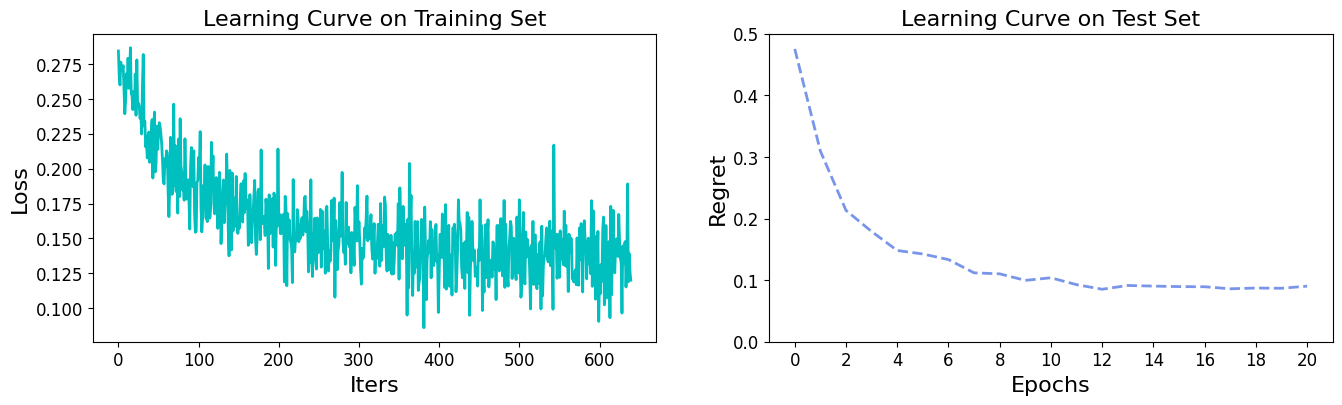

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

4.4.4 Adaptive Implicit Maximum Likelihood Estimator

Adaptive Implicit Maximum Likelihood Estimator (AI-MLE) use the adaptive interpolation step and the perturb-and-MAP framework. They sample noise from a Sum-of-Gamma distribution and interpolate the loss function to approximate finite difference.

First of all, we initialize the predictor.

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.implicitMLE`` allows us to set a Maximum Likelihood loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``distribution``: noise distribution
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [ ]:
# init i-mle solver
aimle = pyepo.func.adaptiveImplicitMLE(optmodel, n_samples=10, sigma=1.0, processes=2)

# set loss
l1 = nn.L1Loss()

# loss function
def ilmel1(cp, w):
    # perturbed optimizer
    we = aimle(cp)
    # loss
    loss = l1(we, w)
    return loss

Num of cores: 2


##### Training

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=ilmel1, method_name="aimle")

Epoch  1,  Loss:    0.2575,  Regret: 48.3107%
Epoch  2,  Loss:    0.2250,  Regret: 26.6225%
Epoch  3,  Loss:    0.1794,  Regret: 15.5359%
Epoch  4,  Loss:    0.1119,  Regret:  9.8700%
Epoch  5,  Loss:    0.1356,  Regret:  8.3453%
Epoch  6,  Loss:    0.1206,  Regret:  7.8115%
Epoch  7,  Loss:    0.1081,  Regret:  7.4108%
Epoch  8,  Loss:    0.1137,  Regret:  7.6108%
Epoch  9,  Loss:    0.2031,  Regret:  7.5621%
Epoch 10,  Loss:    0.1312,  Regret:  7.4771%
Epoch 11,  Loss:    0.1713,  Regret:  7.3202%
Epoch 12,  Loss:    0.1400,  Regret:  7.2911%
Epoch 13,  Loss:    0.1725,  Regret:  7.2328%
Epoch 14,  Loss:    0.1800,  Regret:  7.2148%
Epoch 15,  Loss:    0.1813,  Regret:  7.2310%
Epoch 16,  Loss:    0.1787,  Regret:  7.2575%
Epoch 17,  Loss:    0.1069,  Regret:  7.2542%
Epoch 18,  Loss:    0.2363,  Regret:  7.2089%
Epoch 19,  Loss:    0.1362,  Regret:  7.2980%
Epoch 20,  Loss:    0.1581,  Regret:  7.3836%
Total Elapsed Time: 9529.09 Sec.


##### Learning Curve

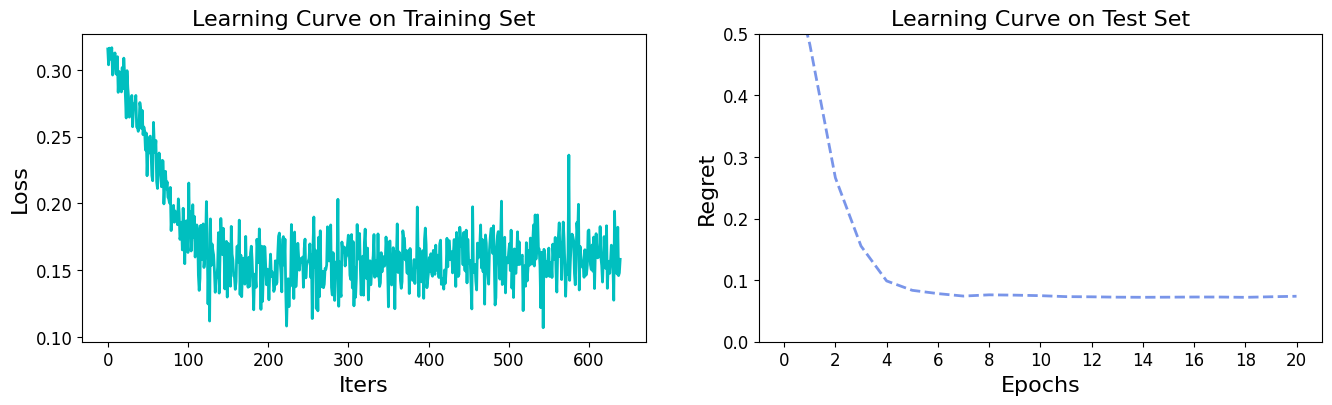

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

### 4.5 Black-Box Methods

#### 4.5.1 Differentiable Black-Box Optimizer

[Pogančić, M. V., Paulus, A., Musil, V., Martius, G., & Rolinek, M. (2020). Differentiation of blackbox combinatorial solvers. In International Conference on Learning Representations.](https://arxiv.org/abs/1912.02175)

Differentiable black-box optimizer estimates gradients from interpolation, replacing the zero gradients. For differentiable block-box, the objective function is linear and constraints are known and fixed, but the cost vector need to be predicted from contextual data.

First of all, we initialize the predictor

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.blackboxOpt`` allows us to set a differentiable solver, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``lambd``: a parameter to contral interpolation degree
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores

In [ ]:
# init dbb solver
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def dbbl1(cp, c, z):
    # black-box optimizer
    wp = dbb(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

Num of cores: 2


##### Training

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=dbbl1, method_name="dbb")

Epoch  1,  Loss:    0.7789,  Regret: 25.4697%
Epoch  2,  Loss:    0.5615,  Regret: 13.2748%
Epoch  3,  Loss:    0.3443,  Regret: 11.8991%
Epoch  4,  Loss:    0.3116,  Regret: 10.7298%
Epoch  5,  Loss:    0.2383,  Regret: 10.2704%
Epoch  6,  Loss:    0.2415,  Regret: 11.0284%
Epoch  7,  Loss:    0.5855,  Regret: 10.1771%
Epoch  8,  Loss:    0.6411,  Regret: 13.1038%
Epoch  9,  Loss:    0.3815,  Regret: 12.9812%
Epoch 10,  Loss:    0.2226,  Regret: 13.7838%
Epoch 11,  Loss:    0.1061,  Regret: 15.6008%
Epoch 12,  Loss:    0.2421,  Regret: 11.1225%
Epoch 13,  Loss:    0.4749,  Regret: 14.5289%
Epoch 14,  Loss:    0.6381,  Regret: 15.6615%
Epoch 15,  Loss:    0.4328,  Regret: 20.9965%
Epoch 16,  Loss:    1.1717,  Regret: 17.9577%
Epoch 17,  Loss:    0.4877,  Regret: 16.2392%
Epoch 18,  Loss:    0.3276,  Regret: 18.6051%
Epoch 19,  Loss:    0.4407,  Regret: 13.7075%
Epoch 20,  Loss:    0.4859,  Regret: 14.8656%
Total Elapsed Time: 2351.73 Sec.


##### Learning Curve

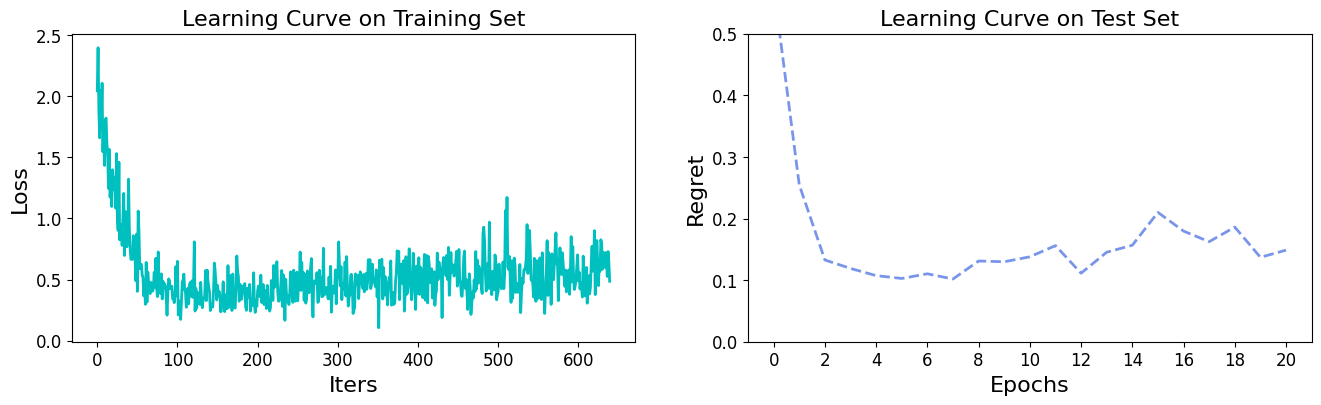

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

#### 4.5.2 Negative Identity Backpropagation (NID)

[Sahoo, S. S., Paulus, A., Vlastelica, M., Musil, V., Kuleshov, V., & Martius, G. (2022). Backpropagation through combinatorial algorithms: Identity with projection works. arXiv preprint arXiv:2205.15213.](https://arxiv.org/abs/2205.15213)

Negative Identity Backpropagation (NID) treats the solver as a negative identity mapping during the backward pass, which is equivalent to DBB with certain hyperparameter. It is hyperparameter-free and does not require any additional computationally expensive call to the solver on the backward pass.

First of all, we initialize the predictor

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.blackboxOpt`` allows us to set a differentiable solver, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores

In [ ]:
# init dbb solver
nid = pyepo.func.negativeIdentity(optmodel, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def nidl1(cp, c, z):
    # black-box optimizer
    wp = nid(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

Num of cores: 2


##### Training

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=nidl1, method_name="nid")

Epoch  1,  Loss:    1.0781,  Regret: 33.4760%
Epoch  2,  Loss:    0.8191,  Regret: 25.0326%
Epoch  3,  Loss:    1.4682,  Regret: 20.1558%
Epoch  4,  Loss:    0.3696,  Regret: 16.6634%
Epoch  5,  Loss:    0.4027,  Regret: 15.0435%
Epoch  6,  Loss:    0.2838,  Regret: 13.8132%
Epoch  7,  Loss:    0.1789,  Regret: 12.9595%
Epoch  8,  Loss:    0.8213,  Regret: 12.0990%
Epoch  9,  Loss:    0.5328,  Regret: 11.1408%
Epoch 10,  Loss:    0.2249,  Regret: 10.8284%
Epoch 11,  Loss:    0.3570,  Regret: 10.8114%
Epoch 12,  Loss:    0.2575,  Regret: 10.3655%
Epoch 13,  Loss:    0.3957,  Regret: 10.2132%
Epoch 14,  Loss:    0.1481,  Regret: 10.0912%
Epoch 15,  Loss:    0.5230,  Regret: 10.0563%
Epoch 16,  Loss:    0.2118,  Regret: 10.0136%
Epoch 17,  Loss:    0.1792,  Regret:  9.9537%
Epoch 18,  Loss:    0.3061,  Regret:  9.7981%
Epoch 19,  Loss:    0.3246,  Regret:  9.7213%
Epoch 20,  Loss:    0.3862,  Regret:  9.5071%
Total Elapsed Time: 1151.52 Sec.


##### Learning Curve

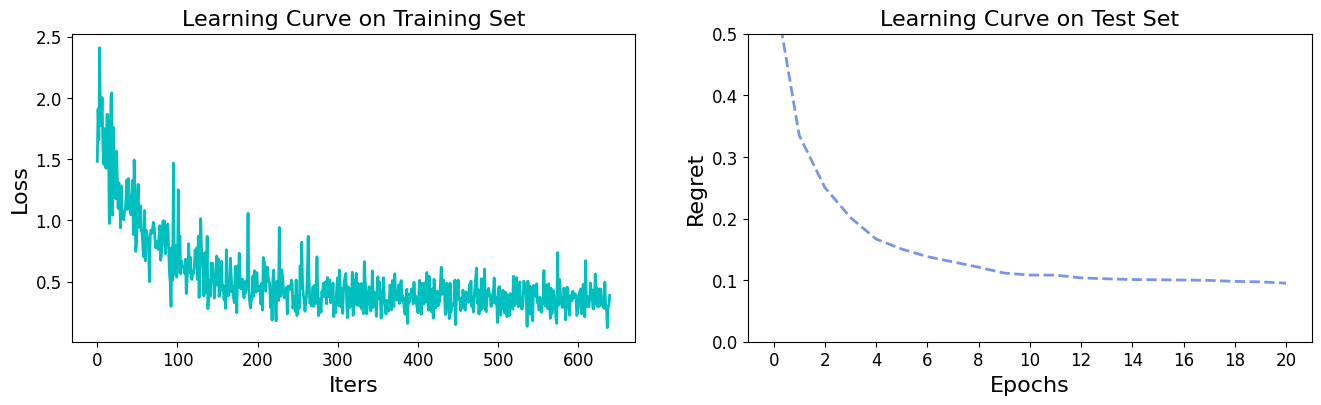

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

### 4.6 Contrastive Estimation

[Mulamba, M., Mandi, J., Diligenti, M., Lombardi, M., Bucarey, V., & Guns, T. (2021). Contrastive losses and solution caching for predict-and-optimize. Proceedings of the Thirtieth International Joint Conference on Artificial Intelligence.](https://www.ijcai.org/proceedings/2021/390)

#### 4.6.1 Noise Contrastive Estimation

It uses a noise contrastive approach to motivate a family of surrogate loss functions, based on viewing non-optimal solutions as negative examples. For the NCE, the cost vector needs to be predicted from contextual data and maximizes the separation of the probability of the optimal solution.

First of all, we initialize the predictor

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.NCE`` allows us to use a noise contrastive estimiation loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores
- ``solve_ratio``: the ratio of new solutions computed during training
- ``dataset``: a dataset to initialize the solution pool with. Usually this is simply the training set

In [ ]:
nce = pyepo.func.NCE(optmodel, processes=2, solve_ratio=0.05, dataset=dataset_train)

Num of cores: 2


##### Training

To compute noise contrastive estimation loss, ``nce`` requires $\mathbf{\hat{c}}$ and $\mathbf{w}^*_{\mathbf{c}}$.

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=nce, method_name="nce")

Epoch  1,  Loss:   -3.9142,  Regret: 22.3516%
Epoch  2,  Loss:   -8.5975,  Regret: 14.3556%
Epoch  3,  Loss:  -11.8960,  Regret: 12.8562%
Epoch  4,  Loss:  -15.7358,  Regret: 11.7744%
Epoch  5,  Loss:  -28.3505,  Regret: 11.6603%
Epoch  6,  Loss:  -19.2389,  Regret: 11.5566%
Epoch  7,  Loss:  -20.4684,  Regret: 11.0967%
Epoch  8,  Loss:  -24.8248,  Regret: 11.0323%
Epoch  9,  Loss:  -41.5554,  Regret: 10.8870%
Epoch 10,  Loss:  -39.5773,  Regret: 10.8941%
Epoch 11,  Loss:  -47.5033,  Regret: 10.7814%
Epoch 12,  Loss:  -56.1769,  Regret: 10.7147%
Epoch 13,  Loss:  -43.5469,  Regret: 10.7080%
Epoch 14,  Loss:  -57.2756,  Regret: 10.7253%
Epoch 15,  Loss:  -60.7738,  Regret: 10.7129%
Epoch 16,  Loss:  -59.1615,  Regret: 10.6151%
Epoch 17,  Loss:  -75.3333,  Regret: 10.5752%
Epoch 18,  Loss:  -54.6215,  Regret: 10.6041%
Epoch 19,  Loss:  -79.4771,  Regret: 10.6193%
Epoch 20,  Loss:  -52.7314,  Regret: 10.5711%
Total Elapsed Time: 104.96 Sec.


##### Learning Curve

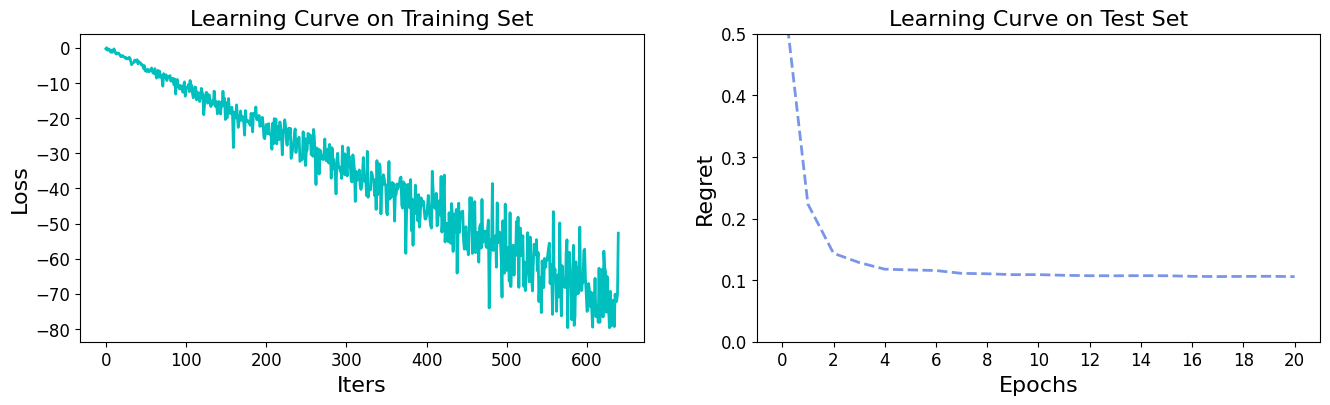

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

#### 4.6.2 Maximum A Posterior

An autograd module for Maximum A Posterior contrastive estimation as surrogate loss functions, which is a efficient self-contrastive algorithm. For the MAP, the cost vector needs to be predicted from contextual data and maximizes the separation of the probability of the optimal solution.

First of all, we initialize the predictor

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.contrastiveMAP`` allows us to use a noise contrastive estimiation loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores
- ``solve_ratio``: the ratio of new solutions computed during training
- ``dataset``: a dataset to initialize the solution pool with. Usually this is simply the training set

In [ ]:
cmap = pyepo.func.contrastiveMAP(optmodel, processes=2, solve_ratio=0.05, dataset=dataset_train)

Num of cores: 2


##### Training

To compute Maximum A Posterior contrastive estimation loss, ``cmap`` requires $\mathbf{\hat{c}}$ and $\mathbf{w}^*_{\mathbf{c}}$.

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=cmap, method_name="cmap")

Epoch  1,  Loss:    0.3018,  Regret: 14.5703%
Epoch  2,  Loss:    0.2677,  Regret:  8.7790%
Epoch  3,  Loss:    0.0897,  Regret:  9.7307%
Epoch  4,  Loss:    0.1427,  Regret: 12.5524%
Epoch  5,  Loss:    0.1050,  Regret: 12.5001%
Epoch  6,  Loss:    0.0582,  Regret: 12.1570%
Epoch  7,  Loss:    0.0528,  Regret: 13.7517%
Epoch  8,  Loss:    0.0520,  Regret: 13.5666%
Epoch  9,  Loss:    0.0973,  Regret: 15.3751%
Epoch 10,  Loss:    0.0811,  Regret: 14.8998%
Epoch 11,  Loss:    0.0532,  Regret: 14.5606%
Epoch 12,  Loss:    0.0963,  Regret: 15.5927%
Epoch 13,  Loss:    0.0706,  Regret: 14.5776%
Epoch 14,  Loss:    0.0576,  Regret: 15.6803%
Epoch 15,  Loss:    0.0902,  Regret: 14.5992%
Epoch 16,  Loss:    0.0446,  Regret: 15.8496%
Epoch 17,  Loss:    0.0736,  Regret: 14.4044%
Epoch 18,  Loss:    0.0462,  Regret: 15.5592%
Epoch 19,  Loss:    0.0271,  Regret: 17.8383%
Epoch 20,  Loss:    0.0635,  Regret: 12.0193%
Total Elapsed Time: 94.62 Sec.


##### Learning Curve

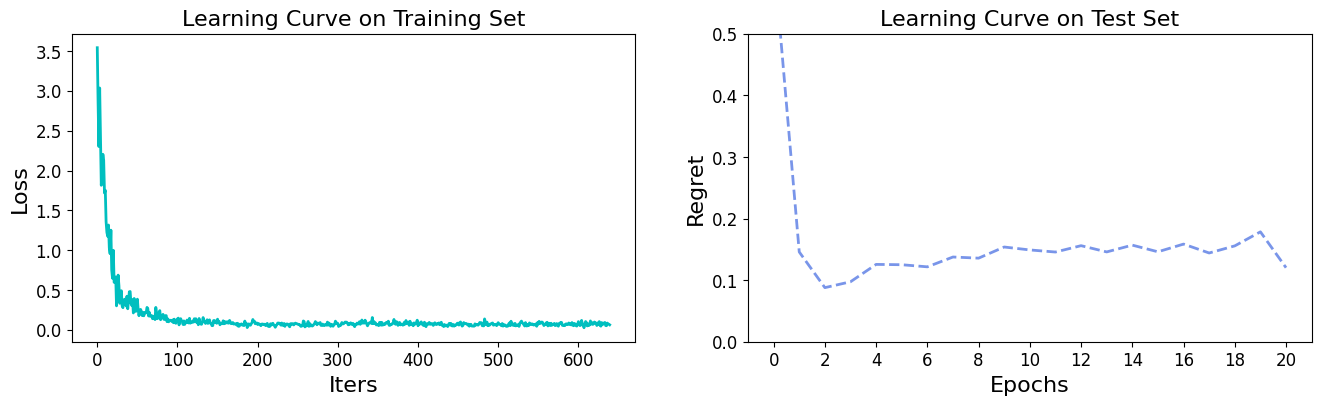

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

### 4.7 Learning To Rank

[Mandi, J., Bucarey, V., Mulamba, M., & Guns, T. (2022). Decision-focused learning: through the lens of learning to rank. Proceedings of the 39th International Conference on Machine Learning.](https://proceedings.mlr.press/v162/mandi22a.html)

#### 4.7.1 Listwise Learning To Rank

A autograd module for listwise learning to rank, where the goal is to learn an objective function that ranks a pool of feasible solutions correctly. For the listwise LTR, the cost vector needs to be predicted from contextual data, and the loss measures the scores of the whole ranked lists.

First of all, we initialize the predictor

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.listwiseLTR`` allows us to use a listwise learning to rank loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores
- ``solve_ratio``: the ratio of new solutions computed during training
- ``dataset``: a dataset to initialize the solution pool with. Usually this is simply the training set

In [ ]:
lsltr = pyepo.func.listwiseLTR(optmodel, processes=2, solve_ratio=0.05, dataset=dataset_train)

Num of cores: 2


##### Training

To compute learning-to-rank loss, ``lsltr`` requires $\mathbf{\hat{c}}$ and $\mathbf{c}$.

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=lsltr, method_name="ltr")

Epoch  1,  Loss:    0.0599,  Regret: 15.2227%
Epoch  2,  Loss:    0.0584,  Regret:  9.6645%
Epoch  3,  Loss:    0.0597,  Regret:  9.4804%
Epoch  4,  Loss:    0.0552,  Regret:  9.7323%
Epoch  5,  Loss:    0.0525,  Regret:  9.7178%
Epoch  6,  Loss:    0.0555,  Regret:  9.5911%
Epoch  7,  Loss:    0.0594,  Regret:  9.7318%
Epoch  8,  Loss:    0.0565,  Regret:  9.4605%
Epoch  9,  Loss:    0.0579,  Regret:  9.1304%
Epoch 10,  Loss:    0.0544,  Regret:  9.0406%
Epoch 11,  Loss:    0.0546,  Regret:  9.7225%
Epoch 12,  Loss:    0.0582,  Regret:  9.7615%
Epoch 13,  Loss:    0.0577,  Regret:  9.2139%
Epoch 14,  Loss:    0.0598,  Regret:  9.3463%
Epoch 15,  Loss:    0.0594,  Regret:  9.7394%
Epoch 16,  Loss:    0.0588,  Regret:  9.3927%
Epoch 17,  Loss:    0.0536,  Regret:  9.4056%
Epoch 18,  Loss:    0.0573,  Regret:  9.3853%
Epoch 19,  Loss:    0.0604,  Regret:  9.5654%
Epoch 20,  Loss:    0.0604,  Regret:  9.4897%
Total Elapsed Time: 78.27 Sec.


##### Learning Curve

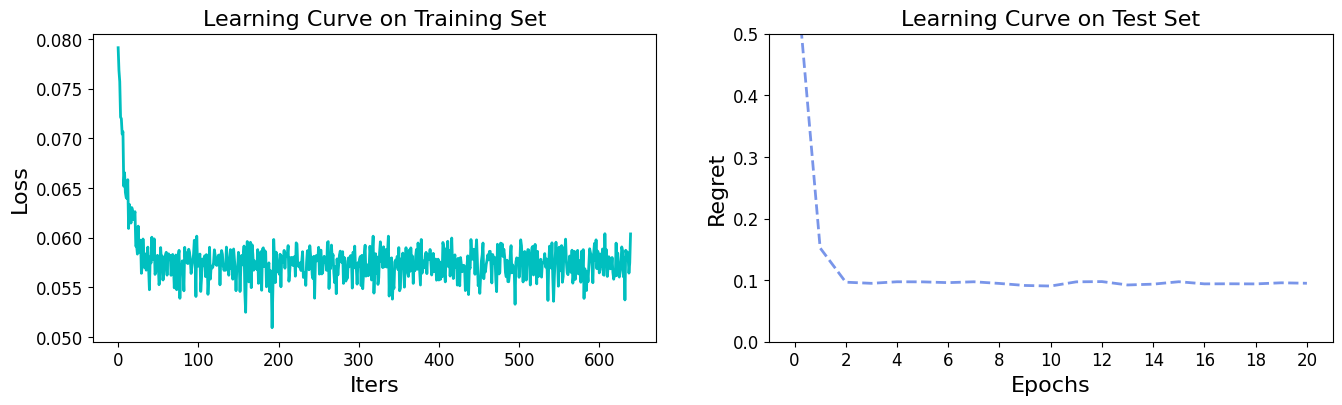

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

#### 4.7.2 Pairwise Learning To Rank

An autograd module for pairwise learning to rank, where the goal is to learn an objective function that ranks a pool of feasible solutions correctly. For the pairwise LTR, the cost vector needs to be predicted from contextual data, and the loss learns the relative ordering of pairs of items.

First of all, we initialize the predictor

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.pairwiseLTR`` allows us to use a listwise learning to rank loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores
- ``solve_ratio``: the ratio of new solutions computed during training
- ``dataset``: a dataset to initialize the solution pool with. Usually this is simply the training set.

In [ ]:
prltr = pyepo.func.pairwiseLTR(optmodel, processes=2, solve_ratio=0.05, dataset=dataset_train)

Num of cores: 2


##### Training

To compute learning-to-rank loss, ``prltr`` requires $\mathbf{\hat{c}}$ and $\mathbf{c}$.

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=prltr, method_name="ltr")

Epoch  1,  Loss:    0.0236,  Regret: 14.4580%
Epoch  2,  Loss:    0.0048,  Regret:  9.1655%
Epoch  3,  Loss:    0.0128,  Regret:  8.2974%
Epoch  4,  Loss:    0.0428,  Regret:  8.4994%
Epoch  5,  Loss:    0.0030,  Regret:  8.2144%
Epoch  6,  Loss:    0.0024,  Regret:  7.9339%
Epoch  7,  Loss:    0.0254,  Regret:  8.3652%
Epoch  8,  Loss:    0.0165,  Regret:  9.2462%
Epoch  9,  Loss:    0.0015,  Regret:  9.6047%
Epoch 10,  Loss:    0.0191,  Regret: 10.5031%
Epoch 11,  Loss:    0.0205,  Regret: 10.3869%
Epoch 12,  Loss:    0.0116,  Regret: 10.5097%
Epoch 13,  Loss:    0.0042,  Regret: 10.2532%
Epoch 14,  Loss:    0.0027,  Regret: 12.3931%
Epoch 15,  Loss:    0.0046,  Regret:  8.6757%
Epoch 16,  Loss:    0.0123,  Regret: 10.7186%
Epoch 17,  Loss:    0.0057,  Regret:  9.7552%
Epoch 18,  Loss:    0.0040,  Regret: 12.3727%
Epoch 19,  Loss:    0.0087,  Regret:  8.3272%
Epoch 20,  Loss:    0.0028,  Regret: 10.8712%
Total Elapsed Time: 345.65 Sec.


##### Learning Curve

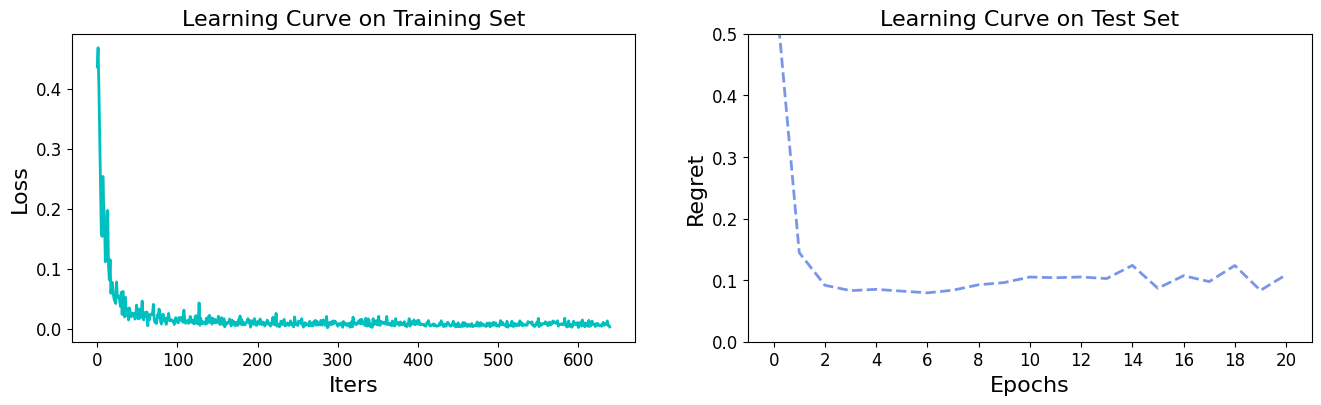

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

#### 4.7.3 Pointwise Learning To Rank

An autograd module for pointwise learning to rank, where the goal is to learn an objective function that ranks a pool of feasible solutions correctly. For the pointwise LTR, the cost vector needs to be predicted from contextual data, and calculates the ranking scores of the items.

First of all, we initialize the predictor

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.pointwiseLTR`` allows us to use a listwise learning to rank loss for training, which requires parameters:
- ``optmodel``: an PyEPO optimization model
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of cores
- ``solve_ratio``: the ratio of new solutions computed during training
- ``dataset``: a dataset to initialize the solution pool with. Usually this is simply the training set

In [ ]:
ptltr = pyepo.func.pointwiseLTR(optmodel, processes=2, solve_ratio=0.05, dataset=dataset_train)

Num of cores: 2


##### Training

To compute learning-to-rank loss, ``ptltr`` requires $\mathbf{\hat{c}}$ and $\mathbf{c}$.

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_func=ptltr, method_name="ltr")

Epoch  1,  Loss:   17.6089,  Regret: 44.3394%
Epoch  2,  Loss:    2.0483,  Regret: 28.4051%
Epoch  3,  Loss:    1.6929,  Regret: 19.1442%
Epoch  4,  Loss:    2.0675,  Regret: 13.6425%
Epoch  5,  Loss:    4.4183,  Regret: 10.5165%
Epoch  6,  Loss:    1.8270,  Regret:  9.0532%
Epoch  7,  Loss:    1.2793,  Regret:  8.2446%
Epoch  8,  Loss:    1.1986,  Regret:  8.2444%
Epoch  9,  Loss:    2.3803,  Regret:  8.2895%
Epoch 10,  Loss:    3.0234,  Regret:  8.5476%
Epoch 11,  Loss:    0.9767,  Regret:  8.6420%
Epoch 12,  Loss:    1.7326,  Regret:  8.6037%
Epoch 13,  Loss:    2.6759,  Regret:  8.3259%
Epoch 14,  Loss:    1.3197,  Regret:  8.6468%
Epoch 15,  Loss:    2.6043,  Regret:  8.5670%
Epoch 16,  Loss:    1.1480,  Regret:  8.6428%
Epoch 17,  Loss:    1.3744,  Regret:  8.4112%
Epoch 18,  Loss:    3.0249,  Regret:  8.4599%
Epoch 19,  Loss:    1.3240,  Regret:  8.6097%
Epoch 20,  Loss:    2.6819,  Regret:  8.3825%
Total Elapsed Time: 89.11 Sec.


##### Learning Curve

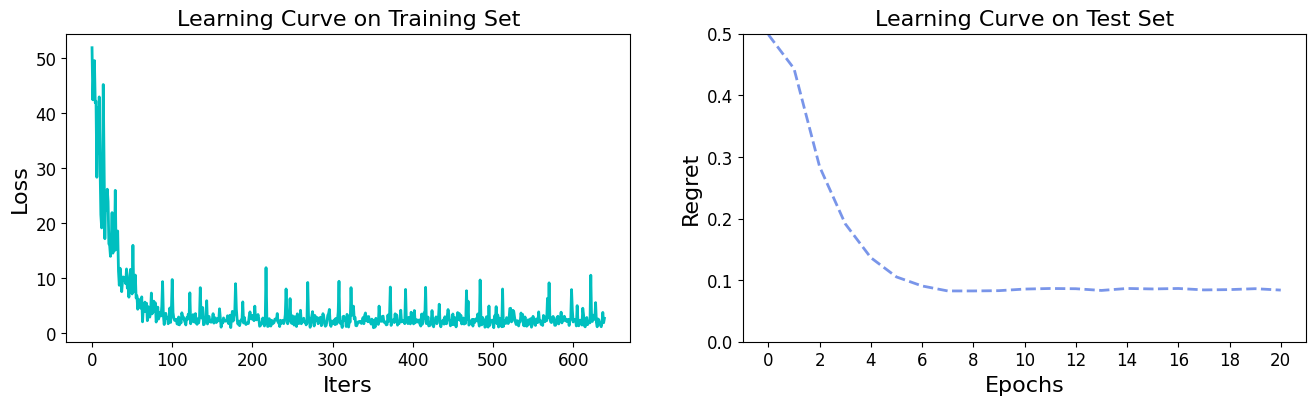

In [ ]:
visLearningCurve(loss_log, loss_log_regret)